Author: Lucas Camponogara Viera.

# Dependencies

In [1]:
import sys
sys.version

'3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]'

In [2]:
# Dummy Dataset
import numpy as np

# File System
import os

# Tensor Manipulation
import torch

# Neural Network
import torch.nn.functional as F
from torch import nn, save, load
from torchsummary import summary

# MNIST Dataset
from torchvision import datasets

# Preprocessing
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Optimizer
from torch.optim import SGD, Adam

# Plotting
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
torch.__version__

'2.7.1+cu118'

In [4]:
for i in range(torch.cuda.device_count()):
    print(f'GPU {i}: {torch.cuda.get_device_name(i)}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU 0: NVIDIA L40S
GPU 1: NVIDIA L40S


# Dummy Dataset

To test the neural network implementation.

In [4]:
# Dummy dataset:
num_classes = 10
num_samples = 100
height = 28
width = height
num_channels = 1 # Grayscale.
train_shape = (num_samples, num_channels, height, width)
label_shape = (num_samples, num_classes)

# Normalizing the dataset:
mean = 0.0 # Mean.
stddev = 1.0 # Standard deviation.

# NumPy:
#dummy_x = np.random.normal(mean, stddev, size=train_shape)
#dummy_y = np.random.randint(0, num_classes, size=(num_samples,))

# Torch:
dummy_x = torch.randn(train_shape) * stddev + mean
dummy_y = torch.randint(0, num_classes, (num_samples,)) # PyTorch's nn.CrossEntropyLoss() expects targets (labels) to be integer class
                                                        # indices. It applies log-softmax to the model outputs (logits) internally.

print(dummy_x.mean(), dummy_x.std()) 
dummy_x.shape, dummy_y.shape, dummy_y[:3]

tensor(0.0005) tensor(0.9992)


(torch.Size([100, 1, 28, 28]), torch.Size([100]), tensor([0, 8, 3]))

In [5]:
# Hold-out set:

x_train = dummy_x[:50] # First 50.
y_train = dummy_y[:50]
x_val = dummy_x[50:] # Remaining ones.
y_val = dummy_y[50:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([50, 1, 28, 28]),
 torch.Size([50]),
 torch.Size([50, 1, 28, 28]),
 torch.Size([50]))

# OOP (Sequential API)

The Sequential API allows neural network layers to be stacked one after another, sequentially. 

- Recommended for simple, linear models where each layer has exactly one input and one output.
- Not recommended for non-linear models with multiple inputs/outputs, shared layers, or branched architectures (e.g., ResNets, Inception, GANs, Transformer, etc).

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1, stride=1, bias=True),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=True),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*14*14, 50),
            nn.ReLU(),
            nn.Linear(50, num_classes),
            #nn.Softmax(dim=1) # Commented line since nn.CrossEntropyLoss() already applies LogSoftmax internally.
        )

    def forward(self, x):
        '''Forward pass method.'''
        x = self.conv_block(x)
        #print(x.size()) # torch.Size([10, 64, 14, 14])
        # Flattening:
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

In [8]:
num_classes = 10
model = NeuralNetwork(num_classes).to(device)
sample_input = torch.ones((10, 1, 28, 28)).to(device)
model(sample_input).shape                        

torch.Size([10, 10])

In [9]:
# input_shape is (channel, height, width)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
              ReLU-6           [-1, 64, 14, 14]               0
            Linear-7                   [-1, 50]         627,250
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
Total params: 646,640
Trainable params: 646,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.81
Params size (MB): 2.47
Estimated Total Size (MB): 3.28
-------------------------------------------

# OOP (Functional API)

The Functional API provides a method for building a neural network model as a Directed Acyclic Graph (DAG) of layers. 

- Recommended for non-linear models with multiple inputs/outputs, shared layers, or branched architectures.
    - Example: Implementing a residual block with skip connections. 

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1, stride=1, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=True)
        self.fc1 = nn.Linear(64 * 14 * 14, 50)  
        self.fc2 = nn.Linear(50, num_classes)
        self.bn = nn.BatchNorm2d(32, affine=True)

    def forward(self, x):
        '''Forward pass method.'''
        x = self.conv1(x)
        x = F.relu(self.bn(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        #print(x.size()) # torch.Size([10, 64, 14, 14])
        # Flattening:
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        #x = F.softmax(self.fc2(x), dim=1) # Commented line since nn.CrossEntropyLoss() already applies LogSoftmax internally.
        x = self.fc2(x) 
        return x

In [11]:
num_classes = 10
model = NeuralNetwork(num_classes).to(device)
sample_input = torch.ones((10, 1, 28, 28)).to(device)
model(sample_input).shape                        

torch.Size([10, 10])

In [12]:
# input_shape is (channel, height, width)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
            Linear-5                   [-1, 50]         627,250
            Linear-6                   [-1, 10]             510
Total params: 646,640
Trainable params: 646,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 2.47
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


# Training with Dummy Dataset

To validate the training loop logic.

In [13]:
# Device ('cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
learning_rate = 1e-4
epochs = 10
batch_size = 10

# Model
model = NeuralNetwork(num_classes=10).to(device)

# Loss
loss = nn.CrossEntropyLoss()

# Optimizers
optimizer = Adam(model.parameters(), learning_rate)
#optimizer = SGD(model.parameters(), learning_rate, momentum=0.9)

In [14]:
for epoch in range(epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_val_correct = 0
    total_val_samples = 0

    # Training phase:
    model.train()  # Set the model to training mode.
    for i in range(0, len(x_train), batch_size):
        # Iterating over the dataset in batches of n samples:
        x_train_batch, y_train_batch = x_train[i:i+batch_size], y_train[i:i+batch_size]
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)

        # Forward pass (prediction):
        yhat_train = model(x_train_batch)

        # Compute training loss:
        train_loss = loss(yhat_train, y_train_batch)
        epoch_train_loss += torch.abs(train_loss).item()

        # Reset gradients:
        optimizer.zero_grad()
        # Backpropagate:
        train_loss.backward()
        # Update weights:
        optimizer.step()

        # Compute training accuracy:
        preds = torch.argmax(yhat_train, dim=1)
        total_train_correct += (preds == y_train_batch).sum().item()
        total_train_samples += y_train_batch.size(0)
    
    # Validation phase:
    model.eval() # Set the model to evaluation mode.
    with torch.no_grad():
        for i in range(0, len(x_val), batch_size):
            x_val_batch, y_val_batch = x_val[i:i+batch_size], y_val[i:i+batch_size]
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

            # Forward pass (prediction):
            yhat_val = model(x_val_batch)

            # Compute validation loss:
            epoch_val_loss += torch.abs(loss(yhat_val, y_val_batch)).item()

            # Compute validation accuracy:
            preds = torch.argmax(yhat_val, dim=1)
            total_val_correct += (preds == y_val_batch).sum().item()
            total_val_samples += y_val_batch.size(0)

    # Number of forward passes:
    num_train_passes = total_train_samples // batch_size
    num_val_passes = total_val_samples // batch_size
    # Average Training Loss:
    epoch_train_loss /= num_train_passes
    # Average Validation Loss:
    epoch_val_loss /= num_val_passes
    # Average Training Accuracy:
    epoch_train_accuracy = total_train_correct / total_train_samples
    # Average Validation Accuracy:
    epoch_val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch: {epoch+1:2d} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy*100:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy*100:.2f}%")

Epoch:  1 | Train Loss: 2.2798 | Train Acc: 10.00% | Val Loss: 2.3235 | Val Acc: 10.00%
Epoch:  2 | Train Loss: 2.0832 | Train Acc: 20.00% | Val Loss: 2.3779 | Val Acc: 10.00%
Epoch:  3 | Train Loss: 1.9706 | Train Acc: 18.00% | Val Loss: 2.4416 | Val Acc: 10.00%
Epoch:  4 | Train Loss: 1.8531 | Train Acc: 58.00% | Val Loss: 2.4905 | Val Acc: 12.00%
Epoch:  5 | Train Loss: 1.7195 | Train Acc: 76.00% | Val Loss: 2.5119 | Val Acc: 14.00%
Epoch:  6 | Train Loss: 1.5680 | Train Acc: 78.00% | Val Loss: 2.5178 | Val Acc: 14.00%
Epoch:  7 | Train Loss: 1.4117 | Train Acc: 86.00% | Val Loss: 2.5264 | Val Acc: 14.00%
Epoch:  8 | Train Loss: 1.2425 | Train Acc: 94.00% | Val Loss: 2.5395 | Val Acc: 14.00%
Epoch:  9 | Train Loss: 1.0752 | Train Acc: 94.00% | Val Loss: 2.5588 | Val Acc: 16.00%
Epoch: 10 | Train Loss: 0.9231 | Train Acc: 98.00% | Val Loss: 2.6017 | Val Acc: 14.00%


# Training with MNIST Dataset

## Data Preprocessing

In [15]:
# Load the MNIST dataset:
mnist = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())

# Define dataset split ratios:
total_size = len(mnist)
train_size = int(0.8 * total_size)  # 80% for training.
val_size = total_size - train_size  # 20% for validation.

# Splitting the dataset into training and validation sets:
train_dataset, val_dataset = torch.utils.data.random_split(mnist, [train_size, val_size])

# Create data loaders for training and validation sets:
batch_size = 32
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)

## Training

In [17]:
# Hyperparameters:
learning_rate = 1e-4
momentum = 0.9
epochs = 50
batch_size = batch_size

# Model:
model = NeuralNetwork(num_classes=10).to(device)

# Loss:
loss = nn.CrossEntropyLoss()

# Optimizers:
optimizer = SGD(model.parameters(), learning_rate, momentum = momentum)
#optimizer = Adam(model.parameters(), learning_rate)

In [18]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_val_correct = 0
    total_val_samples = 0
    
    # Training phase:
    model.train()  # Set the model to training mode.
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Forward pass (prediction):
        yhat_train = model(x)

        # Compute loss:
        train_loss = loss(yhat_train, y)
        epoch_train_loss += torch.abs(train_loss).item()

        # Reset gradients:
        optimizer.zero_grad()
        # Backpropagate:
        train_loss.backward()
        # Update weights:
        optimizer.step()

        # Compute accuracy:
        _, predicted = torch.max(yhat_train, 1)
        total_train_correct += (predicted == y).sum().item()
        total_train_samples += y.size(0)

    # Validation phase:
    model.eval() # Set the model to evaluation mode.
    with torch.no_grad():
        for batch in val_loader:
            x_val_batch, y_val_batch = batch
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

            # Forward pass (prediction):
            yhat_val = model(x_val_batch)

            # Compute loss:
            epoch_val_loss += torch.abs(loss(yhat_val, y_val_batch)).item()
            
            # Compute accuracy:
            _, predicted = torch.max(yhat_val, 1)
            total_val_correct += (predicted == y_val_batch).sum().item()
            total_val_samples += y_val_batch.size(0)

    # Average Training Loss:
    epoch_train_loss /= (total_train_samples/batch_size)
    # Average Training Accuracy:
    epoch_train_accuracy = total_train_correct / total_train_samples
    # Average Val Loss:
    epoch_val_loss /= (total_val_samples/batch_size)
    # Average Val Accuracy:
    epoch_val_accuracy = total_val_correct / total_val_samples
    # History:
    history['loss'].append(epoch_train_loss)
    history['accuracy'].append(epoch_train_accuracy)
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)
    
    print(f"Epoch: {epoch+1:2d} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy*100:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy*100:.2f}%")

if not os.path.exists('./models/torch'):
    os.makedirs('./models/torch')
    
with open('./models/torch/mnist_cnn_model.pt', 'wb') as f:
    save(model.state_dict(), f)

Epoch:  1 | Train Loss: 1.3984 | Train Acc: 88.33% | Val Loss: 0.7032 | Val Acc: 93.34%
Epoch:  2 | Train Loss: 0.5591 | Train Acc: 94.97% | Val Loss: 0.4552 | Val Acc: 95.79%
Epoch:  3 | Train Loss: 0.3681 | Train Acc: 96.74% | Val Loss: 0.3317 | Val Acc: 96.72%
Epoch:  4 | Train Loss: 0.2852 | Train Acc: 97.49% | Val Loss: 0.2862 | Val Acc: 97.37%
Epoch:  5 | Train Loss: 0.2371 | Train Acc: 97.87% | Val Loss: 0.2413 | Val Acc: 97.84%
Epoch:  6 | Train Loss: 0.2041 | Train Acc: 98.18% | Val Loss: 0.2325 | Val Acc: 97.87%
Epoch:  7 | Train Loss: 0.1798 | Train Acc: 98.41% | Val Loss: 0.2005 | Val Acc: 98.17%
Epoch:  8 | Train Loss: 0.1629 | Train Acc: 98.58% | Val Loss: 0.1825 | Val Acc: 98.23%
Epoch:  9 | Train Loss: 0.1464 | Train Acc: 98.72% | Val Loss: 0.1625 | Val Acc: 98.46%
Epoch: 10 | Train Loss: 0.1324 | Train Acc: 98.84% | Val Loss: 0.1659 | Val Acc: 98.38%
Epoch: 11 | Train Loss: 0.1234 | Train Acc: 98.92% | Val Loss: 0.1556 | Val Acc: 98.43%
Epoch: 12 | Train Loss: 0.1138 |

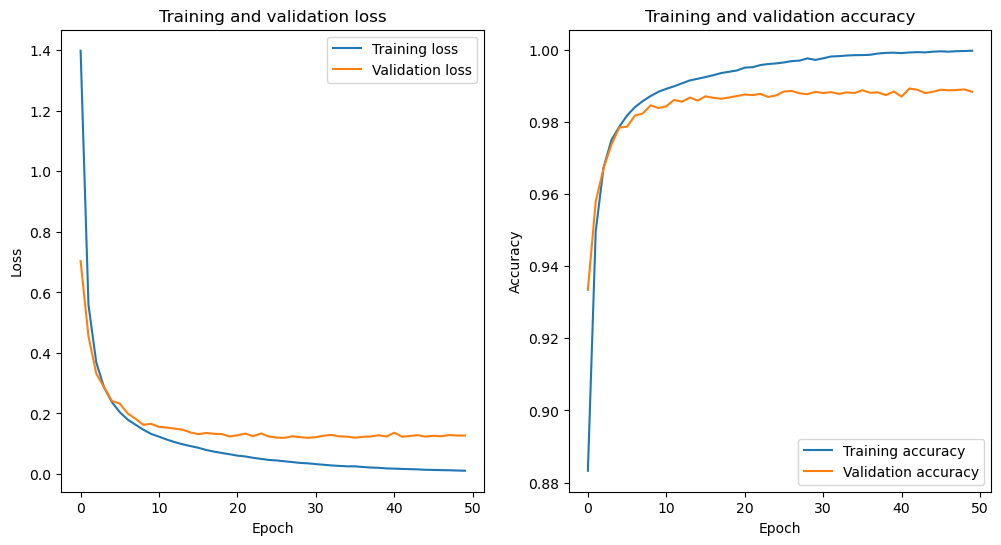

In [19]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training and validation loss
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the training and validation accuracy
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

plot_history(history)

## Predictions

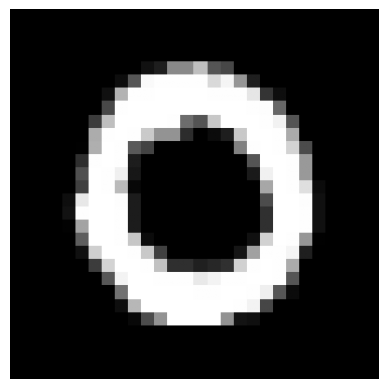

tensor(0, device='cuda:0')


In [20]:
# Open and convert the image to grayscale
img = Image.open('assets/test.png').convert('L')

# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Convert image to Tensor
img = ToTensor()(img).unsqueeze(0)

# Resize the image to match the neural network input
img = F.interpolate(img, size=(28, 28), mode='bilinear', align_corners=False).to(device)

# Load the pre-trained model
with open('models/torch/mnist_cnn_model.pt', 'rb') as f:
    model.load_state_dict(load(f))

# make a prediction
print(torch.argmax(model(img)))